# CODEX Image Processing

In this tutorial, we will go through some crucial steps for CODEX image processing:
1. Some basics about image and how to manipulate images in Python. 
2. Apply a manual (unfortunately this is how it is right now) high pass filter to the image.
3. Put the images into proper format for segmentation using MESMER.
4. Extract single cell information after we obtain the segmentation mask. 

## Essential Packages

Here are the packages that we will be using. 

In [2]:
import tifffile
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

## Image Basics

Here we load the example image into our environment using `tifffile.imread`.

In [63]:
img = tifffile.imread('/mnt/nfs/home/huayingqiu/INDEPTH/run_041624/data/INDEPTH_DLBCL_Left_Scan1.qptiff')

Let's preview the image with `tifffile.imshow`. 

(<Figure size 988.8x604.8 with 3 Axes>,
 <AxesSubplot: >,
 <matplotlib.image.AxesImage at 0x7fad343b24c0>)

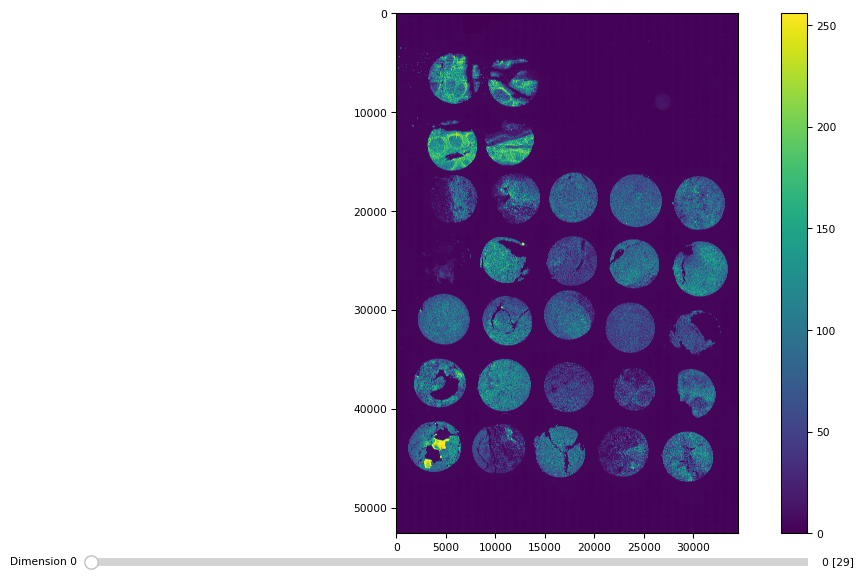

In [4]:
tifffile.imshow(img)

The first important thing about an image that we should realize is that an image is just an array/matrix of numbers.

In [14]:
print(img[0])

[[3 4 3 ... 3 4 4]
 [4 4 4 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 ...
 [3 3 4 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]]


(<Figure size 988.8x604.8 with 2 Axes>,
 <AxesSubplot: >,
 <matplotlib.image.AxesImage at 0x7fad341a42e0>)

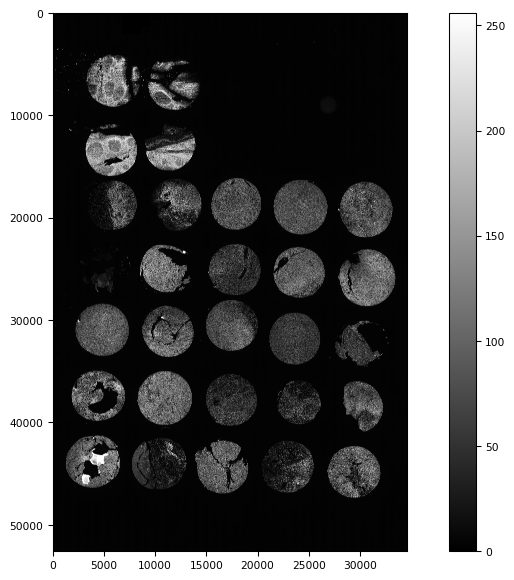

In [16]:
tifffile.imshow(img[0], cmap = 'gray')

The above two chunks showed a matrix of numbers and how the matrix looks if we map each of its elements to a shade on a gray scale. This is how we go from a matrix to a image. Two important things to check about an image are:
- Dimension
- Bit-depth

### Dimension

Usually, the dimension of an image corresponds how many rows and columns of elements we have in the array. We can check the dimension of our example image by calling the `shape` method of our `img` object. 

In [5]:
img.shape

(29, 52560, 34560)

As we can see, the dimension of our image array is 29 x 52560 x 34560. And yes, **an array doesn't have to be 2D**. In fact, this is one of the common forms of CODEX data we generate. The data comes in as a stack of 2D arrays with each 2D array being a unique channel we imaged. Here the dimensions means **channel x height (number of rows in the image array) x width (number of columns in the image array)**. Let's check out some different channels.  

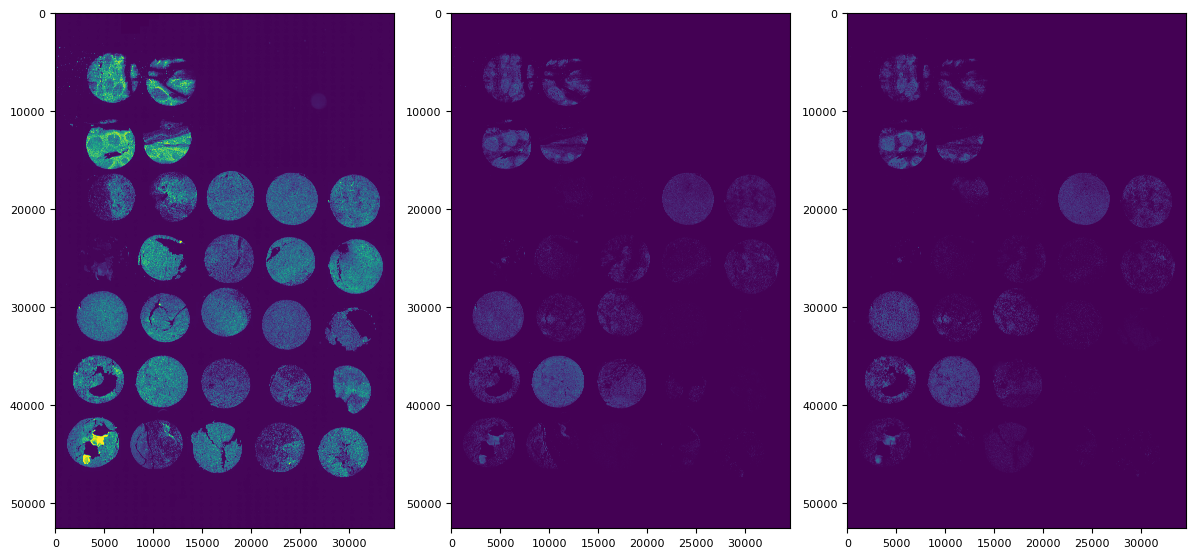

In [18]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(img[0])
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(img[1])
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(img[2])
plt.tight_layout()
plt.show()

### Bit-depth

Recall an image is just a matrix that's rendered by mapping the value to some color map. Bit-depth limits how many shades you can have on the color map. Let's check the bit-depth of our image using the `dtype` method of our `img` object. 

In [13]:
img.dtype

dtype('uint8')

Here we see that the data type of our image is 'uint8' meaning 8 bit unassigned integer. 8 bit is the bit-depth of our data, which means that each element in our image array can represent $2^{8} = 256$ integers from 0 to 255. Each value from 0 to 255 is mapped to one shade on the gray scale, which would also be split into 256 bins. 

## Image manipulation

For demonstration purporses, the downstream tasks will only be carried out on one core of the TMA. We will demonstrate some basic image manipulation techniques along the process.

### Crop an image by slicing the array using indexing

Since an image is just an array of numbers, in order to crop an image, we can just extract the area of numbers that we need. We can do so by slicing the array. 

In [64]:
crop_img = img[:, 41000:48000, 13000:20000]

(<Figure size 988.8x604.8 with 2 Axes>,
 <AxesSubplot: >,
 <matplotlib.image.AxesImage at 0x7fb99395afd0>)

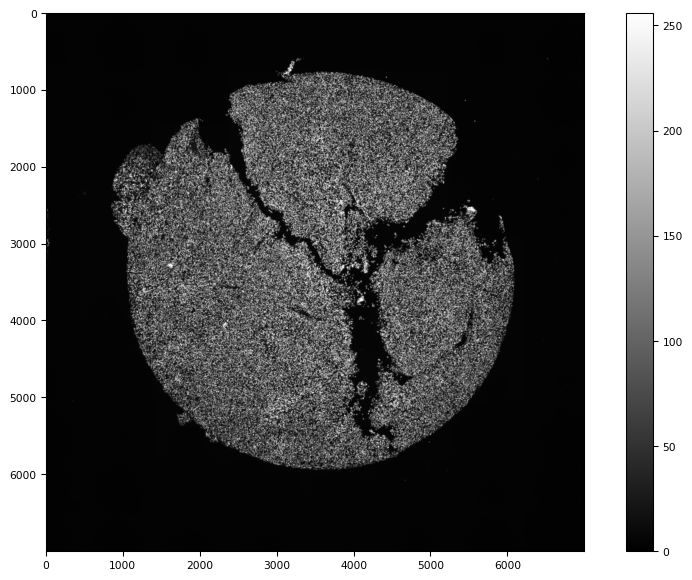

In [50]:
tifffile.imshow(crop_img[0], cmap = 'gray')

In [51]:
crop_img.shape

(29, 7000, 7000)

In [76]:
tifffile.imwrite('../../data_for_tutorial/core.tiff', crop_img)

Here we sliced the array by indexing `[:, 41000:48000, 13000:20000]`. Here the first `:` didn't specify the start and end index of the first dimension, meaning that we don't want to slice the first dimension, which is the channel. This ensured that all the channels of the cropped area are retained in our cropped array. The second position had `41000:48000`, which means that we want to crop the image from 41000 to 48000 in the y direction. Similarly, `13000:20000` means that we want to crop the image from 13000 to 20000 in the x direction. Correspondingly, we subsetted the image array from the 41000th row to the 48000th row and 13000th column to the 20000th column. 

### Rotation

## Manual high-pass filter

As described in the beginning, often times high-pass filters needs to be applied to some channels of the image. We will domestrate the reason by looking at the CD3 channel. 

(<Figure size 988.8x604.8 with 2 Axes>,
 <AxesSubplot: >,
 <matplotlib.image.AxesImage at 0x7face55b8cd0>)

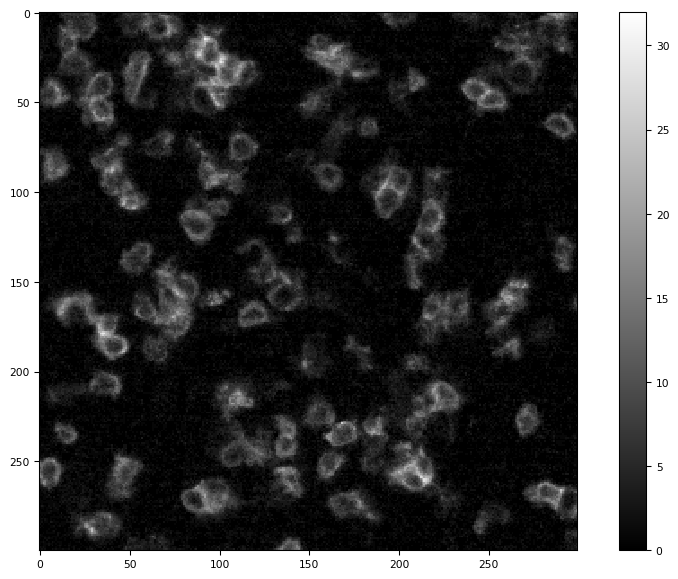

In [67]:
region = crop_img[3, 4000:4300, 3000:3300]

tifffile.imshow(region, cmap = 'gray')

As we know, CD3 is a membrane marker and ideally it should only stain the membrane of a cell. But apparently, the fluorescent signal spilled in to the cytoplasm and nucleus area of the cell in our image and this is often the case. Therefore, to ensure we have the most clean data possible for our downstream analysis, we should remove the unspecific staining of those problematic markers. Based on our observation, unspecific staining usually has lower signal intensity than true signal. Thus, a high-pass filter can slove the problem. However, currently there is no automatic way to do this, so we obtain the desired lower bound by:
1. loading the image in QuPath
2. Increase the minimum display value of the image until we reach a statisfactory display of the image.
3. Record the minimum display value and use it as the lower bound to filter our signal. 

(<Figure size 988.8x604.8 with 2 Axes>,
 <AxesSubplot: >,
 <matplotlib.image.AxesImage at 0x7facf41a19a0>)

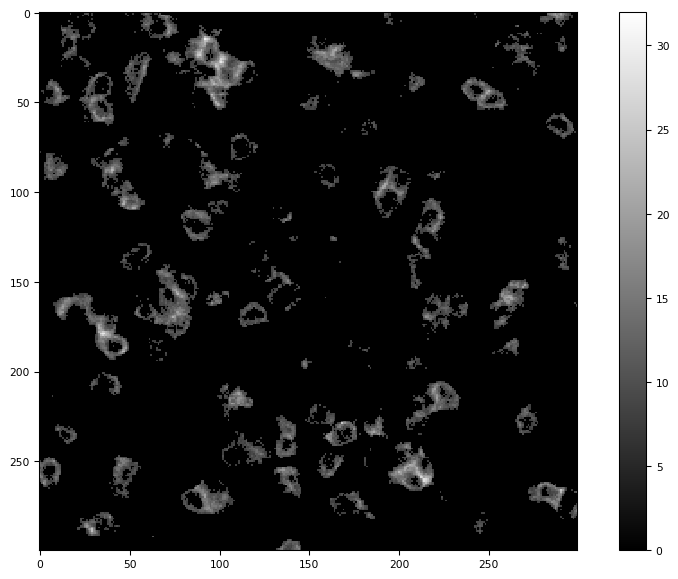

In [74]:
region_filtered = region.copy()
region_filtered[region_filtered < 8] = 0
tifffile.imshow(region_filtered, cmap = 'gray')

As we can see. This got rid of a lot of the background signal and the unspecific staining. 

## Format the data for segmentation

To do:
1. Do the high-pass for CD11b, CD68, CD20, CD163, CD31 and CD3.
2. CD11b, CD68, CD20, CD163, CD31, CD3 are membrane markers that we will be using for segmentation. Combine those into one channel using `np.sum`. 
3. Extract the DAPI channel. We will use it as the nuclear channel for segmentation. 
4. The input image of MESMER needs to be in the format (n, Y, X, channel) with the 1st index of channel being the nuclear channel and the 2nd index being the membrane channel. You will need to stack the nuclear and membrane channel using `np.stack`. Then expand the stacked array to have the 1st dimension using `np.expand_dim`.  

## Segmentation 

After you are done with the above. You can segment the image using the following code. If you are unsure about how to proceed you can either ask me or refer to [this notebook](https://github.com/vanvalenlab/deepcell-tf/blob/master/notebooks/applications/Mesmer-Application.ipynb).

In [77]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="0" # specify visible gpu(s) 0-3
import tensorflow as tf
try:
    tf_gpus = tf.config.list_physical_devices('GPU')
    for gpu in tf_gpus:
        tf.config.experimental.set_memory_growth(gpu, True) # allow memory growth on visible gpu(s)
except:
    pass 

from deepcell.applications import Mesmer
from deepcell.utils.plot_utils import create_rgb_image, make_outline_overlay

In [ ]:
mesmer = Mesmer()
predictions = mesmer.predict({your image stack}, image_mpp = 0.5,
                                postprocess_kwargs_whole_cell={"maxima_threshold" : 0.075,
                                                             "interior_threshold" : 0.05},
compartment = 'nuclear')

rgb_image = create_rgb_image({your image stack}, channel_colors = ["green", "blue"])
overlay = make_outline_overlay(rgb_data = rgb_image, predictions = predictions)